In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_dir = './data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Load VGG16 network and weigts. 550MB in HDF5 format, 16 trainable layers

In [3]:
from keras.applications import VGG16

vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))

vgg_model.summary()

/home/ubuntu/anaconda/envs/py36-venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [5]:
def extract_features(directory, sample_count):
    
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary'
                                           )
    i = 0
    for inputs_batch, labels_batch in generator:
    
        features_batch = vgg_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    return features, labels

## Feature Maps become the Input dataset of the Classifier

In [6]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Flatten feature maps to 1D as inputs of FC layer

In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

## Rebuild and Train a FC Classifier Model

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels)
                   )

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 807us/step - loss: 0.6035 - acc: 0.6680 - val_loss: 0.4423 - val_acc: 0.8260
Epoch 2/30
2000/2000 [==============================] - 1s 344us/step - loss: 0.4297 - acc: 0.8000 - val_loss: 0.3602 - val_acc: 0.8690
Epoch 3/30
2000/2000 [==============================] - 1s 352us/step - loss: 0.3611 - acc: 0.8485 - val_loss: 0.3212 - val_acc: 0.8800
Epoch 4/30
2000/2000 [==============================] - 1s 349us/step - loss: 0.3106 - acc: 0.8695 - val_loss: 0.2980 - val_acc: 0.8910
Epoch 5/30
2000/2000 [==============================] - 1s 352us/step - loss: 0.2850 - acc: 0.8860 - val_loss: 0.2873 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 349us/step - loss: 0.2630 - acc: 0.8960 - val_loss: 0.2746 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 1s 351us/step - loss: 0.2462 - acc: 0.9065 - val_loss: 0.2638 - val_acc: 0.8950


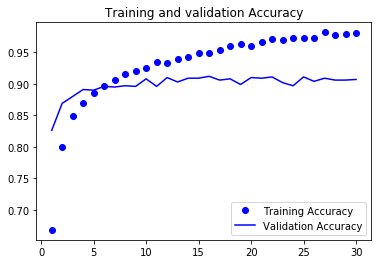

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.show()

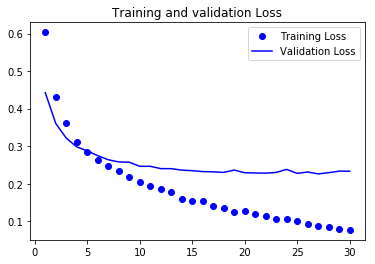

In [11]:
acc = history.history['loss']
val_acc = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Loss')
plt.plot(epochs, val_acc, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()

plt.show()

## Model Weights Saving

In [12]:
model.save('./models/cats_and_dogs_classifier.h5')

## Applying Logistic Regression on the features extracted by CNN

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [14]:
params = {"C": [0.1, 1.0, 10.0, 100.0]}

logistic = LogisticRegression()
lr_model = GridSearchCV(logistic, params, cv=3, n_jobs=2)

lr_model.fit(train_features, train_labels)
print("Best hyper-parameters: {}".format(lr_model.best_params_))

Best hyper-parameters: {'C': 0.1}


## Evaluate the Logistic Regression model

In [15]:
preds = lr_model.predict(validation_features)

report = classification_report(validation_labels, preds, target_names=['cat','dog'])
print("Report: {}".format(report))

acc = accuracy_score(validation_labels, preds)
print("Accuracy: {}".format(acc))

Report:              precision    recall  f1-score   support

        cat       0.89      0.93      0.91       500
        dog       0.93      0.88      0.90       500

avg / total       0.91      0.91      0.91      1000

Accuracy: 0.906
